<a href="https://colab.research.google.com/github/khamzovich/visualization/blob/main/cohort_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.colors as mcolors

In [ ]:
sns.set()

## Load data

In [ ]:
GA_data = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/career_factory/careerfactory_2021_2/GA_data.csv',
    sep=';',
    encoding='cp1251',
    low_memory=False,
    dtype={'Content': object},
    )

GA_data['DateTime'] = pd.to_datetime(GA_data['DateTime'], format='%d.%m.%Y %H:%M:%S')

GA_data.rename(columns={
    'Цель GA — Добавить в корзину': 'added_to_cart',
    'Цель GA — Кнопка перехода в корзину после кнопки Заказать': 'go_to_cart',
    'Цель GA — Кнопка завершения оформления заказа в корзине': 'order_registration',
    'Цель GA — Успешная оплата заказа': 'order_payment',
    'Цель GA — Финал заказ подтвержден': 'order_confirmed'},
    inplace=True)

GA_data.head(3)

,DateTime,ClientId,SessionCount,Sessions,Source,Medium,Campaign,Content,DeviceCategory,added_to_cart,go_to_cart,order_registration,order_payment,order_confirmed
0,2020-10-01 00:00:00,1962835052.1601499279,1,1,blogger,stories,BloggerCampaignName_153,NaN,mobile,0,1,0,0,0
1,2020-10-01 00:00:00,1299278127.1601499606,1,1,tiktok,community,CommunityPost_226,NaN,mobile,0,0,0,0,0
2,2020-10-01 00:01:00,801061510.1595087868,48,1,yahoo,organic,(not set),NaN,mobile,0,0,1,0,0


In [ ]:
GA_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794107 entries, 0 to 794106
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   DateTime            794107 non-null  datetime64[ns]
 1   ClientId            794107 non-null  object        
 2   SessionCount        794107 non-null  int64         
 3   Sessions            794107 non-null  int64         
 4   Source              794107 non-null  object        
 5   Medium              794107 non-null  object        
 6   Campaign            772299 non-null  object        
 7   Content             66742 non-null   object        
 8   DeviceCategory      794107 non-null  object        
 9   added_to_cart       794107 non-null  int64         
 10  go_to_cart          794107 non-null  int64         
 11  order_registration  794107 non-null  int64         
 12  order_payment       794107 non-null  int64         
 13  order_confirmed     794107 no

In [ ]:
GA_data['DateTime'].agg(['min', 'max'])

min   2020-10-01 00:00:00
max   2020-12-31 23:57:00
Name: DateTime, dtype: datetime64[ns]

## Cohort analysis

Weekly cohort analysis with retention

In [ ]:
# DateTime to week
GA_data['week'] = GA_data['DateTime'].astype('datetime64[W]')

In [ ]:
# dataframe with first users weeks
user = GA_data[GA_data.order_confirmed == 1].groupby('ClientId')['week'].min().reset_index()
user.columns = ['ClientId', 'first_week']
user

,ClientId,first_week
0,10000097.1608233444,2020-12-17
1,1000254551.1580073897,2020-10-22
2,1000677863.1608287927,2020-12-17
3,10007218.1606421158,2020-11-26
4,1001057578.1605388391,2020-11-12
...,...,...
9022,999551392.1606495171,2020-11-26
9023,999585220.1606474538,2020-11-26
9024,999738308.1602224278,2020-10-08
9025,999749821.1602235576,2020-10-08


In [ ]:
# dataframe with confirmed orders
confirmed_orders = GA_data[GA_data.order_confirmed == 1]

In [ ]:
# confirmed orders amount (count / nunique)
n_confirmed_orders = confirmed_orders.groupby(['week'])['ClientId'].agg(['count','nunique'])
n_confirmed_orders

,count,nunique
week,,
2020-10-01,535,434
2020-10-08,697,575
2020-10-15,518,415
2020-10-22,761,645
2020-10-29,700,561
2020-11-05,497,419
2020-11-12,654,534
2020-11-19,1573,1326
2020-11-26,1431,1101


In [ ]:
# dataframe with weeks from confirmed_orders
df_week = pd.DataFrame(sorted(confirmed_orders.week.unique()))
df_week.columns = ['week']
df_week

,week
0,2020-10-01
1,2020-10-08
2,2020-10-15
3,2020-10-22
4,2020-10-29
5,2020-11-05
6,2020-11-12
7,2020-11-19
8,2020-11-26
9,2020-12-03


In [ ]:
# add key column for cross join
user['key'] = 1     
df_week['key'] = 1

# template with users and all weeks
template = user.merge(df_week, on='key')[['ClientId', 'first_week', 'week']]
template.shape

(126378, 3)

In [ ]:
template.head(3)

,ClientId,first_week,week
0,10000097.1608233444,2020-12-17,2020-10-01
1,10000097.1608233444,2020-12-17,2020-10-08
2,10000097.1608233444,2020-12-17,2020-10-15


In [ ]:
# save rows with week greater or equal first_week
template = template[template['week'] >= template['first_week']]

In [ ]:
GA_data.head(3)

,DateTime,ClientId,SessionCount,Sessions,Source,Medium,Campaign,Content,DeviceCategory,added_to_cart,go_to_cart,order_registration,order_payment,order_confirmed,week
0,2020-10-01 00:00:00,1962835052.1601499279,1,1,blogger,stories,BloggerCampaignName_153,NaN,mobile,0,1,0,0,0,2020-10-01
1,2020-10-01 00:00:00,1299278127.1601499606,1,1,tiktok,community,CommunityPost_226,NaN,mobile,0,0,0,0,0,2020-10-01
2,2020-10-01 00:01:00,801061510.1595087868,48,1,yahoo,organic,(not set),NaN,mobile,0,0,1,0,0,2020-10-01


In [ ]:
# dataframe with weekly order_confirmed information for every user
active_week = GA_data.groupby(['ClientId', 'week'])['order_confirmed'].sum().reset_index()
active_week['active'] = (active_week.order_confirmed > 0) * 1
active_week.shape

(480598, 4)

In [ ]:
active_week.head(3)

,ClientId,week,order_confirmed,active
0,1000002598.1608113627,2020-12-10,0,0
1,1000004931.1608741477,2020-12-17,0,0
2,10000097.1608233444,2020-12-17,1,1


In [ ]:
# how=left save missed values in template
report = template.merge(active_week, on=['ClientId', 'week'], how='left')
report.shape

(63623, 5)

In [ ]:
report.head(3)

,ClientId,first_week,week,order_confirmed,active
0,10000097.1608233444,2020-12-17,2020-12-17,1.0,1.0
1,10000097.1608233444,2020-12-17,2020-12-24,NaN,NaN
2,10000097.1608233444,2020-12-17,2020-12-31,NaN,NaN


In [ ]:
retention = report.pivot_table(index='first_week', columns='week', values='active', aggfunc='mean')

## Diagram

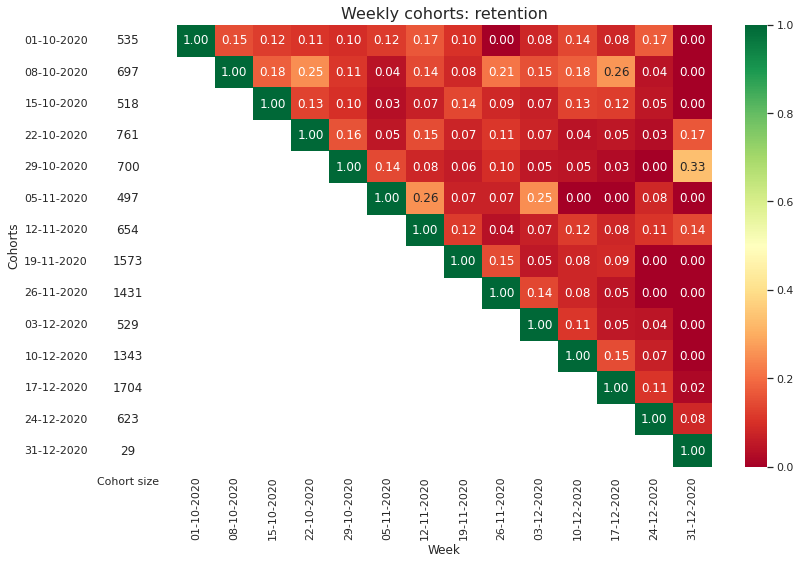

In [ ]:
with sns.axes_style("white"):
  fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

  # retention matrix
  sns.heatmap(
      retention,
      mask=retention.isnull(),
      cmap='RdYlGn',
      annot=True,
      fmt='.2f',
      ax=ax[1])
    
  # cohort size
  cohort_size_df = pd.DataFrame(n_confirmed_orders['count']).rename(columns={'count': 'Cohort size'})
  white_cmap = mcolors.ListedColormap(['white'])
  sns.heatmap(
      cohort_size_df, 
      annot=True, 
      cbar=False, 
      fmt='g',
      cmap=white_cmap, 
      ax=ax[0])
    
  ax[1].set_xticklabels(df_week['week'].dt.strftime('%d-%m-%Y'))
  ax[1].set_yticklabels(df_week['week'].dt.strftime('%d-%m-%Y'))
  ax[1].set_title('Weekly cohorts: retention', fontsize=16)
  ax[1].set(xlabel='Week',
            ylabel='')
  ax[0].set(ylabel='Cohorts')

  fig.tight_layout()